<a href="https://colab.research.google.com/github/johnfriesen/tree_envelope_in_bavarian_cities/blob/main/Merge_climate_envelope_Bavarian_Cities.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install geopandas rasterstats

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 62.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 66.8 MB/s eta 0:00:00


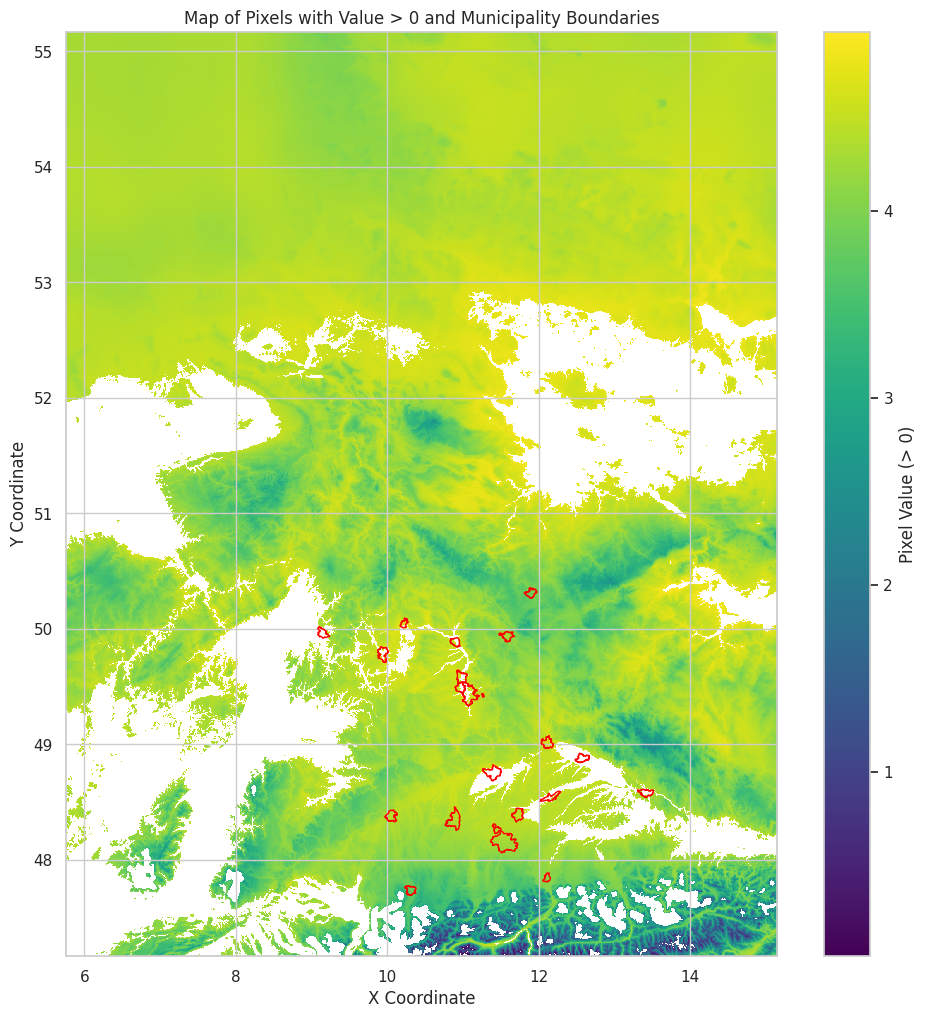

In [20]:
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show
import geopandas as gpd
import numpy as np

# Define file paths
raster_path = "Rotbuche_2071-2100.tif"
shapefile_path = "VG250_GEM.shp"

# Load the raster and read channel one
with rasterio.open(raster_path) as src:
    raster_data = src.read(1)  # first band
    transform = src.transform
    # Create a version of the raster that only keeps pixels > 0, others set to nan
    raster_valid = np.where(raster_data > 0, raster_data, np.nan)
    bounds = src.bounds  # used for plotting the raster correctly

# Load the shapefile
gdf = gpd.read_file(shapefile_path)

# Define your list of ARS codes
ars_list = [
    "091620000000", "095640000000", "097610000000", "093620000000",
    "091610000000", "096630000000", "095630000000", "095620000000",
    "094610000000", "094620000000", "096610000000", "092610000000",
    "097630000000", "091630000000",
    "097750135135", "096620000000", "092620000000", "091780124124",
    "092630000000", "091740115115",
    "094640000000"
]
gdf_filtered = gdf[gdf['ARS_0'].isin(ars_list)]

# Reproject the shapefile to the raster's CRS if needed
if gdf_filtered.crs != src.crs:
    gdf_filtered = gdf_filtered.to_crs(src.crs)

# Plot the raster and municipality boundaries
fig, ax = plt.subplots(figsize=(12, 12))
# Plot the raster with extent defined by the raster bounds (to correctly position pixels)
im = ax.imshow(raster_valid,
               extent=[bounds.left, bounds.right, bounds.bottom, bounds.top],
               cmap='viridis',
               interpolation='none')
# Overlay municipality boundaries
gdf_filtered.boundary.plot(ax=ax, edgecolor='red', linewidth=1)

# Add a colorbar for the raster
cbar = fig.colorbar(im, ax=ax)
cbar.set_label('Pixel Value (> 0)')

ax.set_title('Map of Pixels with Value > 0 and Municipality Boundaries')
ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')
plt.show()


           ARS_0  TOTAL_PIXELS  VALID_PIXELS  NO_INFO_PIXELS   PCT_VALID
0   091610000000           236            24             212   10.169492
1   091620000000           538           538               0  100.000000
2   091630000000            62            62               0  100.000000
3   091740115115            59            59               0  100.000000
4   091780124124           157           146              11   92.993631
5   092610000000           115            37              78   32.173913
6   092620000000           125            36              89   28.800000
7   092630000000           121             0             121    0.000000
8   093620000000           140           140               0  100.000000
9   094610000000           100            46              54   46.000000
10  094620000000           119           119               0  100.000000
11  094640000000           108           108               0  100.000000
12  095620000000           137            77       

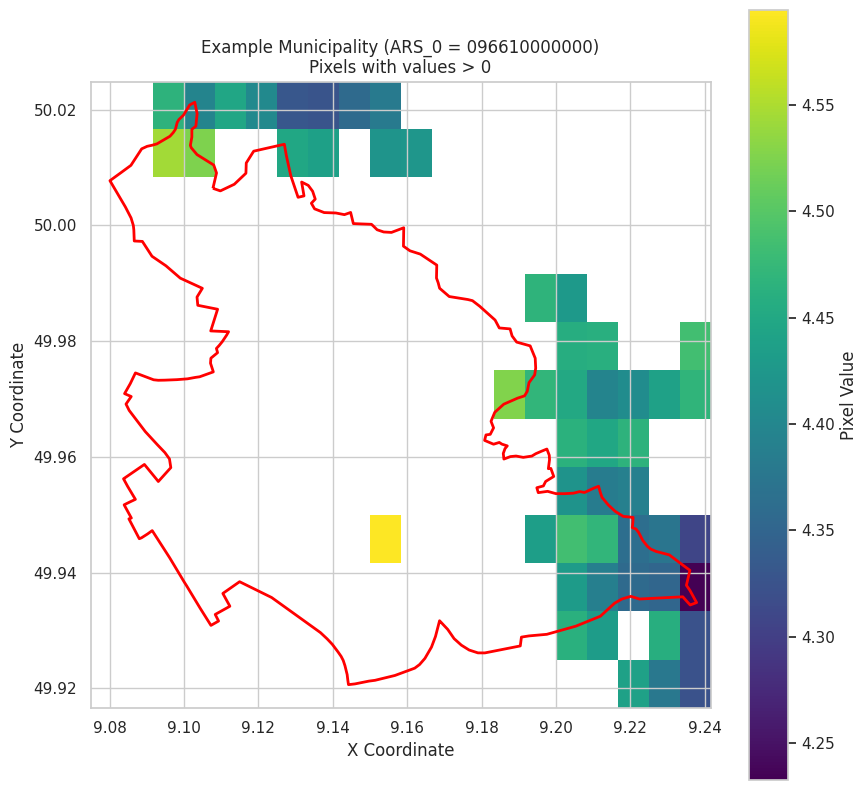

In [19]:
import geopandas as gpd
import rasterio
from rasterio.mask import mask
from rasterio.features import geometry_mask
import numpy as np
import pandas as pd
from shapely.geometry import box
import matplotlib.pyplot as plt

# File paths
raster_path = "Rotbuche_2071-2100.tif"
shapefile_path = "VG250_GEM.shp"

# Load the shapefile and filter by ARS codes
gdf = gpd.read_file(shapefile_path)
ars_list = [
    "091620000000", "095640000000", "097610000000", "093620000000",
    "091610000000", "096630000000", "095630000000", "095620000000",
    "094610000000", "094620000000", "096610000000", "092610000000",
    "097630000000", "091630000000",
    "097750135135", "096620000000", "092620000000", "091780124124",
    "092630000000", "091740115115",
    "094640000000"
]
gdf_filtered = gdf[gdf['ARS_0'].isin(ars_list)]

results = []

with rasterio.open(raster_path) as src:
    # Reproject the GeoDataFrame if needed so the CRS matches the raster
    if gdf_filtered.crs != src.crs:
        gdf_filtered = gdf_filtered.to_crs(src.crs)

    for idx, row in gdf_filtered.iterrows():
        polygon = row.geometry

        # Use mask() to get the raster values over the polygon's bounding box.
        # filled=True returns a full array (with nodata values filled in).
        out_image, out_transform = mask(
            src,
            [polygon.__geo_interface__],
            crop=True,
            all_touched=True,
            filled=True
        )
        data_filled = out_image[0]  # First band

        # Create a binary mask of the polygon using geometry_mask.
        # Set invert=True so that pixels inside the polygon are True.
        poly_mask = geometry_mask(
            [polygon.__geo_interface__],
            out_shape=data_filled.shape,
            transform=out_transform,
            invert=True
        )

        # Count total pixels inside the polygon based on the geometry mask.
        total_pixels = np.sum(poly_mask)  # True is 1; gives count of pixels inside

        # Count valid pixels: pixels inside the polygon (poly_mask True) with values > 0.
        valid_pixels = np.sum((data_filled > 0) & poly_mask)

        # "No information" pixels are those inside the polygon that are not valid.
        no_info_pixels = total_pixels - valid_pixels

        pct_valid = (valid_pixels / total_pixels * 100) if total_pixels > 0 else 0

        results.append({
            "ARS_0": row["ARS_0"],
            "TOTAL_PIXELS": int(total_pixels),
            "VALID_PIXELS": int(valid_pixels),
            "NO_INFO_PIXELS": int(no_info_pixels),
            "PCT_VALID": pct_valid
        })

df_results = pd.DataFrame(results)
print(df_results)

# ---------------------------
# Plot a map showing the pixels (values > 0)
# ---------------------------
# For visualization, we create a raster version where pixels outside the polygon are masked.
# Here we'll use the first municipality from our filtered set for demonstration.

# Let's pick one municipality (e.g., the first one)
example_geom = [gdf_filtered.iloc[15].geometry.__geo_interface__]

with rasterio.open(raster_path) as src:
    out_image, out_transform = mask(src, example_geom, crop=True, all_touched=True, filled=False)
    data = out_image[0]  # masked array

# Create a plot
fig, ax = plt.subplots(figsize=(10, 10))
# Plot the masked array. The masked areas will not be shown.
im = ax.imshow(data.data,
               extent=(
                   out_transform[2],
                   out_transform[2] + out_transform[0] * data.shape[1],
                   out_transform[5] + out_transform[4] * data.shape[0],
                   out_transform[5]),
               cmap='viridis',
               interpolation='none')

# Overlay the boundary of the example municipality
gdf_filtered.iloc[[15]].boundary.plot(ax=ax, edgecolor='red', linewidth=2)

ax.set_title(f"Example Municipality (ARS_0 = {gdf_filtered.iloc[15]['ARS_0']})\nPixels with values > 0")
ax.set_xlabel("X Coordinate")
ax.set_ylabel("Y Coordinate")
fig.colorbar(im, ax=ax, label='Pixel Value')
plt.show()


           City                   Species Time_Frame  TOTAL_PIXELS  \
0    Ingolstadt                  Rotbuche  2011-2040           236   
1    Ingolstadt                  Rotbuche  2041-2070           236   
2    Ingolstadt                  Rotbuche  2071-2100           236   
3    Ingolstadt                Spitzahorn  2011-2040           236   
4    Ingolstadt                Spitzahorn  2041-2070           236   
..          ...                       ...        ...           ...   
751     Neu-Ulm           Gemeine Robinie  2041-2070           143   
752     Neu-Ulm           Gemeine Robinie  2071-2100           143   
753     Neu-Ulm  Gewöhnliche Rosskastanie  2011-2040           143   
754     Neu-Ulm  Gewöhnliche Rosskastanie  2041-2070           143   
755     Neu-Ulm  Gewöhnliche Rosskastanie  2071-2100           143   

     VALID_PIXELS   PCT_VALID  
0             236  100.000000  
1             236  100.000000  
2              24   10.169492  
3             236  100.000000  

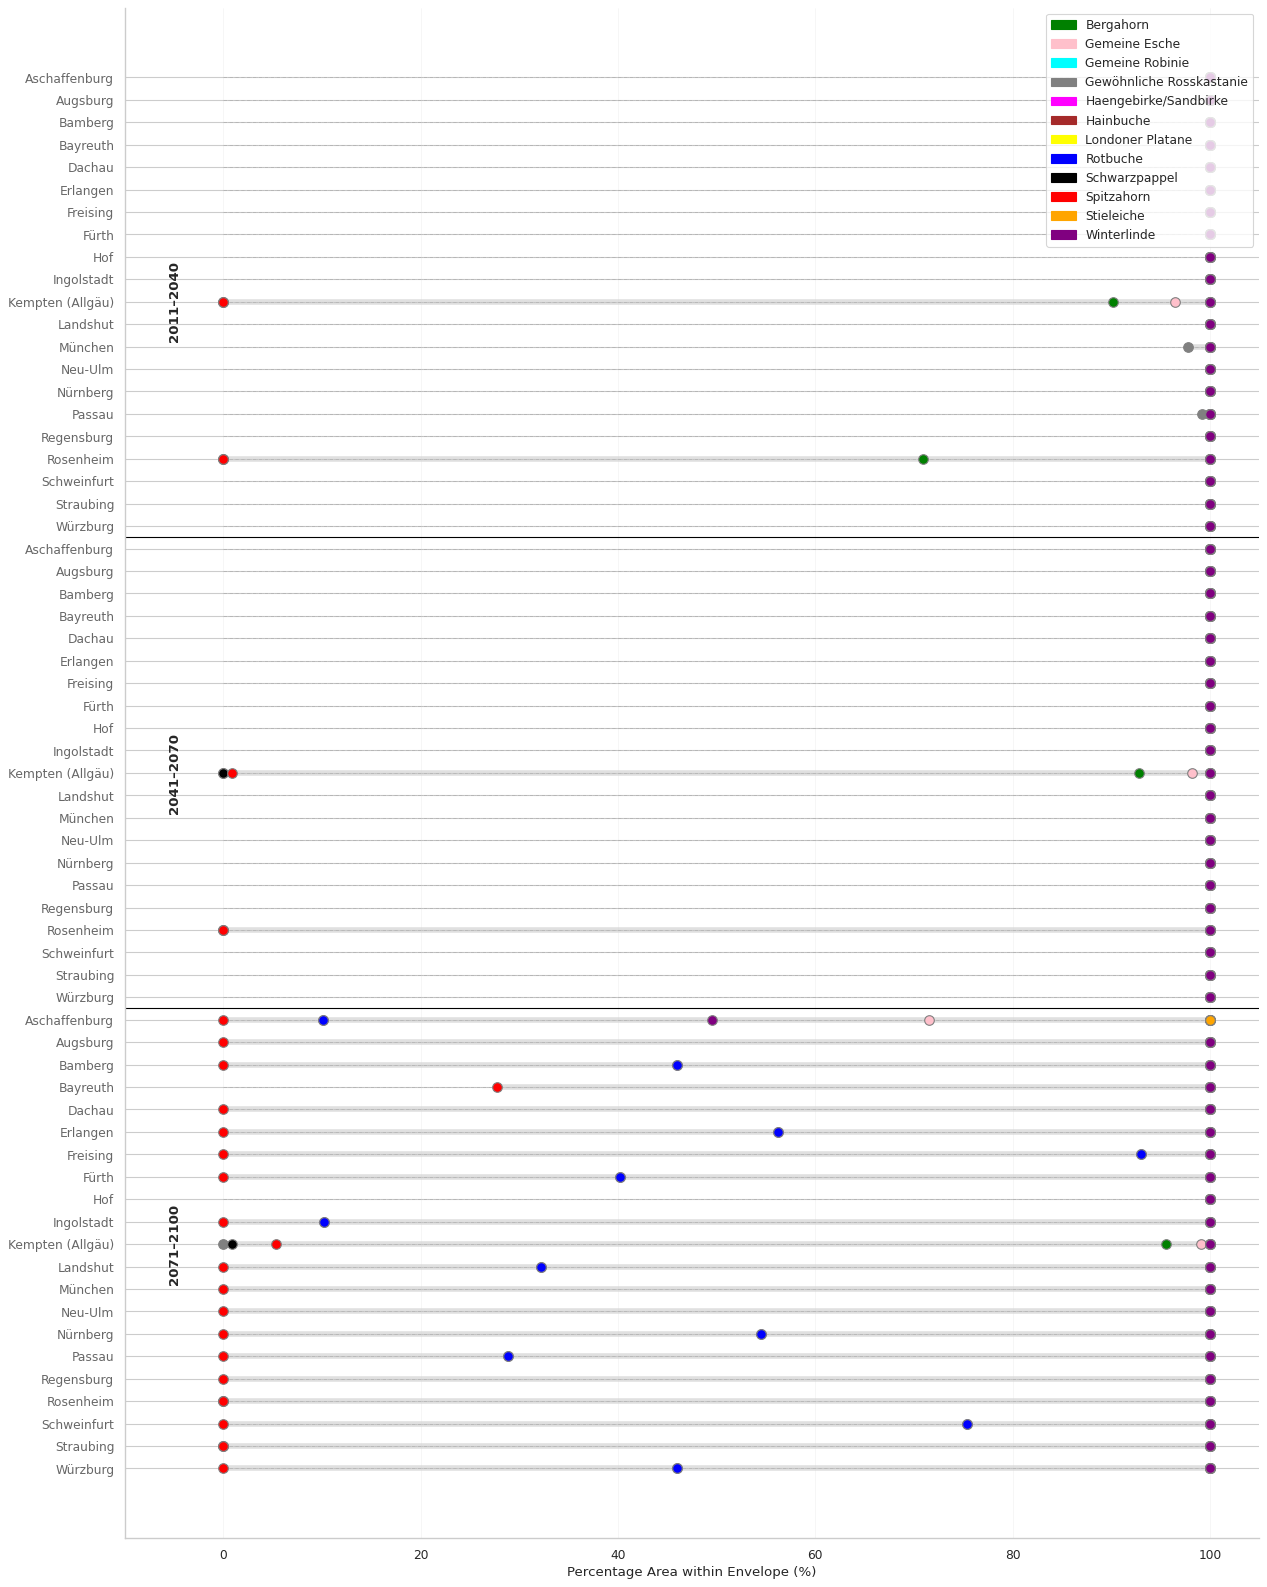

In [8]:
import geopandas as gpd
import rasterio
from rasterio.mask import mask
from rasterio.features import geometry_mask
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# -----------------------------------------------------------------
# 1. Set up the mapping of (species, time_frame) to raster file paths
# -----------------------------------------------------------------
raster_files = {
    ('Rotbuche', '2011-2040'): "Rotbuche_2011-2040.tif",
    ('Rotbuche', '2041-2070'): "Rotbuche_2041-2070.tif",
    ('Rotbuche', '2071-2100'): "Rotbuche_2071-2100.tif",
    ('Spitzahorn', '2011-2040'): "Spitzahorn_2011-2040.tif",
    ('Spitzahorn', '2041-2070'): "Spitzahorn_2041-2070.tif",
    ('Spitzahorn', '2071-2100'): "Spitzahorn_2071-2100.tif",
    ('Bergahorn', '2011-2040'): "Bergahorn_2011-2040.tif",
    ('Bergahorn', '2041-2070'): "Bergahorn_2041-2070.tif",
    ('Bergahorn', '2071-2100'): "Bergahorn_2071-2100.tif",
    ('Stieleiche', '2011-2040'): "Stieleiche_2011-2040.tif",
    ('Stieleiche', '2041-2070'): "Stieleiche_2041-2070.tif",
    ('Stieleiche', '2071-2100'): "Stieleiche_2071-2100.tif",
    ('Winterlinde', '2011-2040'): "Winterlinde_2011-2040.tif",
    ('Winterlinde', '2041-2070'): "Winterlinde_2041-2070.tif",
    ('Winterlinde', '2071-2100'): "Winterlinde_2071-2100.tif",
    ('Haengebirke/Sandbirke', '2011-2040'): "Haengebirke_Sandbirke_2011-2040.tif",
    ('Haengebirke/Sandbirke', '2041-2070'): "Haengebirke_Sandbirke_2041-2070.tif",
    ('Haengebirke/Sandbirke', '2071-2100'): "Haengebirke_Sandbirke_2071-2100.tif",
    ('Schwarzpappel', '2011-2040'): "Schwarz_pappel_2011-2040.tif",
    ('Schwarzpappel', '2041-2070'): "Schwarz_pappel_2041-2070.tif",
    ('Schwarzpappel', '2071-2100'): "Schwarz_pappel_2071-2100.tif",
    ('Hainbuche', '2011-2040'): "Hainbuche_2011-2040.tif",
    ('Hainbuche', '2041-2070'): "Hainbuche_2041-2070.tif",
    ('Hainbuche', '2071-2100'): "Hainbuche_2071-2100.tif",
    ('Gemeine Esche', '2011-2040'): "Gemeine_Esche_2011-2040.tif",
    ('Gemeine Esche', '2041-2070'): "Gemeine_Esche_2041-2070.tif",
    ('Gemeine Esche', '2071-2100'): "Gemeine_Esche_2071-2100.tif",
    ('Londoner Platane', '2011-2040'): "nh2011_Londoner_Platane.tif",
    ('Londoner Platane', '2041-2070'): "nh2041_Londoner_Platane.tif",
    ('Londoner Platane', '2071-2100'): "nh2071_Londoner_Platane.tif",
    ('Gemeine Robinie', '2011-2040'): "Gemeine_Robinie_2011-2040.tif",
    ('Gemeine Robinie', '2041-2070'): "Gemeine_Robinie_2041-2070.tif",
    ('Gemeine Robinie', '2071-2100'): "Gemeine_Robinie_2071-2100.tif",
    ('Gewöhnliche Rosskastanie', '2011-2040'): "nh2011_Gewoehnliche_Rosskastanie.tif",
    ('Gewöhnliche Rosskastanie', '2041-2070'): "nh2041_Gewoehnliche_Rosskastanie.tif",
    ('Gewöhnliche Rosskastanie', '2071-2100'): "nh2071_Gewoehnliche_Rosskastanie.tif"
}

# -----------------------------------------------------------------
# 2. Load the shapefile and filter by your ARS list (if needed)
#    We'll use the "GEN" column for city names.
# -----------------------------------------------------------------
shapefile_path = "VG250_GEM.shp"
gdf = gpd.read_file(shapefile_path)

ars_list = [
    "091620000000", "095640000000", "097610000000", "093620000000",
    "091610000000", "096630000000", "095630000000", "095620000000",
    "094610000000", "094620000000", "096610000000", "092610000000",
    "097630000000", "091630000000",
    "097750135135", "096620000000", "092620000000", "091780124124",
    "092630000000", "091740115115",
    "094640000000"
]
gdf_filtered = gdf[gdf['ARS_0'].isin(ars_list)].copy()

# -----------------------------------------------------------------
# 3. Define a function to compute pixel metrics for a given polygon and raster.
# -----------------------------------------------------------------
def get_polygon_metrics(raster_path, polygon):
    with rasterio.open(raster_path) as src:
        # Extract the raster values over the polygon's bounding box.
        out_image, out_transform = mask(src, [polygon.__geo_interface__],
                                        crop=True, all_touched=True, filled=True)
        data_filled = out_image[0]  # first band

        # Create a geometry mask based solely on the polygon.
        poly_mask = geometry_mask([polygon.__geo_interface__],
                                  out_shape=data_filled.shape,
                                  transform=out_transform,
                                  invert=True)
        # Count total pixels inside the polygon (using the geometry mask)
        total_pixels = np.sum(poly_mask)
        # Count valid pixels (inside the polygon with value > 0)
        valid_pixels = np.sum((data_filled > 0) & poly_mask)
        pct_valid = (valid_pixels / total_pixels * 100) if total_pixels > 0 else 0

    return int(total_pixels), int(valid_pixels), pct_valid

# -----------------------------------------------------------------
# 4. Reproject the shapefile to the CRS of the rasters.
#    Here, we assume all rasters share the same CRS.
# -----------------------------------------------------------------
# Get the CRS from one of the rasters:
first_raster = list(raster_files.values())[0]
with rasterio.open(first_raster) as src:
    raster_crs = src.crs

if gdf_filtered.crs != raster_crs:
    gdf_filtered = gdf_filtered.to_crs(raster_crs)

# -----------------------------------------------------------------
# 5. Loop over each city (using the "GEN" column for names)
#    and each raster (species and time_frame) to compute metrics.
# -----------------------------------------------------------------
results = []
for idx, row in gdf_filtered.iterrows():
    city_name = row["GEN"]
    polygon = row.geometry
    for (species, time_frame), raster_file in raster_files.items():
        total_pixels, valid_pixels, pct_valid = get_polygon_metrics(raster_file, polygon)
        results.append({
            "City": city_name,
            "Species": species,
            "Time_Frame": time_frame,
            "TOTAL_PIXELS": total_pixels,
            "VALID_PIXELS": valid_pixels,
            "PCT_VALID": pct_valid
        })

df_results = pd.DataFrame(results)
print(df_results)
df_results.to_csv('results.csv', index=False)

# -----------------------------------------------------------------
# 6. Plotting: Prepare data and create a horizontal dot plot
#    comparing the percentage valid pixels for each city.
# -----------------------------------------------------------------
# Pivot the data for each time frame so that rows are cities and columns are tree species.
def pivot_time_frame(df, time_frame):
    group = df[df['Time_Frame'] == time_frame].pivot(index='City', columns='Species', values='PCT_VALID').reset_index()
    return group

group1 = pivot_time_frame(df_results, '2011-2040')
group2 = pivot_time_frame(df_results, '2041-2070')
group3 = pivot_time_frame(df_results, '2071-2100')

# Compute uncertainty margins dynamically over all species columns.
for group in [group1, group2, group3]:
    species_cols = [col for col in group.columns if col != 'City']
    group['Uncertainty_Min'] = group[species_cols].min(axis=1)
    group['Uncertainty_Max'] = group[species_cols].max(axis=1)

# Record the number of rows per group.
n1 = group1.shape[0]
n2 = group2.shape[0]
n3 = group3.shape[0]

# Concatenate the groups in order (earliest time frame first).
df_all = pd.concat([group1, group2, group3], ignore_index=True)

# Create y positions for each row and get city labels.
y_positions = np.arange(df_all.shape[0])
ytick_labels = df_all['City'].tolist()

# ----- Plotting -----
fig, ax = plt.subplots(figsize=(16, 20), dpi=80)

# Draw horizontal guide lines for each row (x-axis from 0 to 100%).
ax.hlines(y=y_positions, xmin=0, xmax=100, color='gray', alpha=0.5, linewidth=0.5, linestyles='dashdot')

# Draw thicker uncertainty margin lines behind the dots.
for i, row in df_all.iterrows():
    ax.hlines(y=i, xmin=row['Uncertainty_Min'], xmax=row['Uncertainty_Max'],
              color='lightgrey', linewidth=5, alpha=0.7, zorder=1)

# Define colors for every species.
colors = {
    'Rotbuche': 'blue',
    'Spitzahorn': 'red',
    'Bergahorn': 'green',
    'Stieleiche': 'orange',
    'Winterlinde': 'purple',
    'Hainbuche': 'brown',
    'Gemeine Esche': 'pink',
    'Gemeine Robinie': 'cyan',
    'Haengebirke/Sandbirke': 'magenta',
    'Schwarzpappel': 'black',
    'Londoner Platane': 'yellow',
    'Gewöhnliche Rosskastanie': 'gray'
}

# Determine species columns (all columns except 'City', 'Uncertainty_Min', and 'Uncertainty_Max').
species_columns = [col for col in df_all.columns if col not in ['City', 'Uncertainty_Min', 'Uncertainty_Max']]

# Plot dots for each species for every row.
for i, row in df_all.iterrows():
    for species in species_columns:
        ax.scatter(row[species], i, s=75, color=colors.get(species, 'black'),
                   edgecolors='gray', zorder=3)

# Set y-ticks to show city names.
ax.set_yticks(y_positions)
ax.set_yticklabels(ytick_labels, fontdict={'horizontalalignment': 'right'}, alpha=0.7)

# Invert the y-axis so that the earliest group appears on top.
ax.invert_yaxis()

# Add horizontal separator lines between time frame groups.
sep1 = n1 - 0.5
sep2 = n1 + n2 - 0.5
ax.axhline(y=sep1, color='black', linewidth=1)
ax.axhline(y=sep2, color='black', linewidth=1)

# Add period labels next to each group.
center_group1 = (n1 - 1) / 2
center_group2 = n1 + (n2 - 1) / 2
center_group3 = n1 + n2 + (n3 - 1) / 2
x_label = -5  # adjust x offset for period labels

ax.text(x_label, center_group1, "2011–2040", ha='center', va='center',
        rotation=90, fontsize=12, fontweight='bold')
ax.text(x_label, center_group2, "2041–2070", ha='center', va='center',
        rotation=90, fontsize=12, fontweight='bold')
ax.text(x_label, center_group3, "2071–2100", ha='center', va='center',
        rotation=90, fontsize=12, fontweight='bold')

# Set x-axis label and limits.
ax.set_xlabel('Percentage Area within Envelope (%)', fontsize=12)
ax.set_xlim(-10, 105)

# Build a legend with a patch for each species.
patches = [mpatches.Patch(color=colors[sp], label=sp) for sp in species_columns]
plt.legend(handles=patches, loc='upper right')

# Remove top and right spines for a cleaner look.
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Add light vertical grid lines.
ax.grid(axis='x', alpha=0.3, linewidth=0.5)

plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd

# Specify the path to your CSV file
csv_path = "baumkataster_stadt_wuerzburg.csv"  # Adjust the filename as needed

# Load the CSV file into a DataFrame, using the delimiter ';' and handling bad lines with a warning
df = pd.read_csv(csv_path, delimiter=';', on_bad_lines='warn')

# Count total trees in the cadaster
total_trees = len(df)

# Define the specific tree species (inside the climate envelope) to count.
# Adjust the names to match exactly those in the "Baumart deutsch" column.
tree_species = [
    "Spitz-Ahorn",
    "SPITZ-AHORN SCHWEDLERI",
    "SPITZAHORN COLUMNARE",
    "SPITZAHORN EUROSTAR",
    "SPITZAHORN EMERALD QUEEN",
    "SPITZAHORN NORWEGIAN SUNSET",
    "SPITZAHORN 'ROYAL RED'",
    "SPITZAHORN 'DEBORAH'"
]

# Filter the DataFrame to include only rows where "Baumart deutsch" is one of the specified species
filtered_df = df[df["Baumart deutsch"].isin(tree_species)]

# Count the number of trees per species inside the climate envelope
tree_counts = filtered_df["Baumart deutsch"].value_counts()

# Calculate the number of trees outside the climate envelope
trees_inside = total_trees - len(filtered_df)

# Calculate the percentage of trees outside the climate envelope
percentage_inside = (trees_inside / total_trees) * 100

# Output the results
print("Total number of trees in the cadaster:", total_trees)
print("\nTree counts for specified species (outside the climate envelope):")
print(tree_counts)
print("\nNumber of trees inside the climate envelope:", trees_inside)
print("Percentage of trees inside the climate envelope: {:.2f}%".format(percentage_inside))


Total number of trees in the cadaster: 44665

Tree counts for specified species (outside the climate envelope):
Baumart deutsch
Spitz-Ahorn                    3484
Rot-Buche                       585
SPITZAHORN EMERALD QUEEN        236
SPITZAHORN COLUMNARE             67
SPITZAHORN 'ROYAL RED'           43
SPITZAHORN 'DEBORAH'             33
SPITZ-AHORN SCHWEDLERI           21
SPITZAHORN EUROSTAR               2
SPITZAHORN NORWEGIAN SUNSET       1
Name: count, dtype: int64

Number of trees inside the climate envelope: 40193
Percentage of trees inside the climate envelope: 89.99%


Analysis of Landcover Classes in the analysed Bavarian cities.

                   Built-up  Open Soil  Deciduous Wood  Coniferous Wood  \
City                                                                      
Ingolstadt        18.447981   0.315070       13.251982         1.434413   
München           34.661221   0.257888       10.560787         2.019978   
Rosenheim         19.637372   0.004601       16.352074         3.918273   
Dachau            16.192195   0.053096       10.339530         1.941945   
Freising           9.278248   0.171015       14.318696         6.815742   
Landshut          16.655334   0.025536       15.058477         6.347084   
Passau            13.904714   0.019969       21.568110        15.263320   
Straubing         16.050043   0.057506        2.590572         0.103333   
Regensburg        31.018173   1.009955        4.898973         2.088537   
Bamberg           23.708383   0.062389       18.656507        16.444879   
Bayreuth          18.223819   0.037606        9.215773        12.920527   
Hof               17.1432

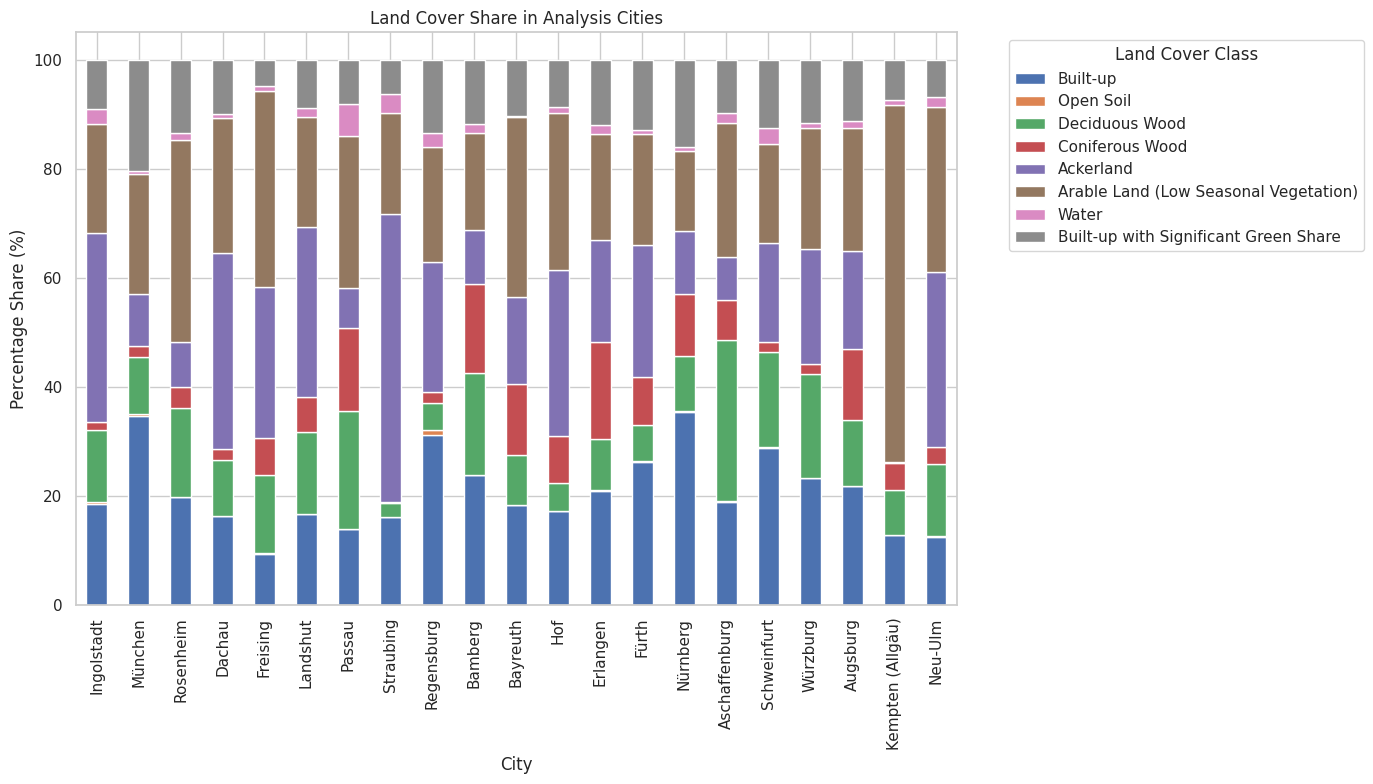

In [9]:
import geopandas as gpd
import rasterio
from rasterio.mask import mask
from rasterio.features import geometry_mask
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ------------------------------
# 1. Load and filter the shapefile
# ------------------------------
shapefile_path = "VG250_GEM.shp"
gdf = gpd.read_file(shapefile_path)

ars_list = [
    "091620000000", "095640000000", "097610000000", "093620000000",
    "091610000000", "096630000000", "095630000000", "095620000000",
    "094610000000", "094620000000", "096610000000", "092610000000",
    "097630000000", "091630000000",
    "097750135135", "096620000000", "092620000000", "091780124124",
    "092630000000", "091740115115",
    "094640000000"
]
gdf_filtered = gdf[gdf['ARS_0'].isin(ars_list)].copy()

# ------------------------------
# 2. Land-cover raster setup
# ------------------------------
# Path to your land-cover GeoTIFF (with 8 classes)
landcover_path = "ugr2018_germany.tif"

# Land-cover classes mapping (1 to 8)
landcover_classes = {
    1: 'Built-up',
    2: 'Open Soil',
    3: 'Deciduous Wood',
    4: 'Coniferous Wood',
    5: 'Ackerland',
    6: 'Arable Land (Low Seasonal Vegetation)',
    7: 'Water',
    8: 'Built-up with Significant Green Share'
}

# Reproject the shapefile to the raster’s CRS if needed.
with rasterio.open(landcover_path) as src:
    landcover_crs = src.crs

if gdf_filtered.crs != landcover_crs:
    gdf_filtered = gdf_filtered.to_crs(landcover_crs)

# ------------------------------
# 3. Calculate land-cover share for each city
# ------------------------------
results_landcover = []

with rasterio.open(landcover_path) as src:
    for idx, row in gdf_filtered.iterrows():
        city = row["GEN"]
        polygon = row.geometry

        # Mask the raster using the city polygon
        out_image, out_transform = mask(src, [polygon.__geo_interface__],
                                        crop=True, all_touched=True, filled=True)
        data = out_image[0]  # assume a single band

        # Create a mask to select only pixels that fall within the polygon
        poly_mask = geometry_mask([polygon.__geo_interface__],
                                  out_shape=data.shape,
                                  transform=out_transform,
                                  invert=True)
        # Extract only the pixels within the polygon
        data_inside = data[poly_mask]
        total_pixels = data_inside.size

        if total_pixels == 0:
            continue

        # Count pixels for each land-cover class (ignoring any nodata or background if present)
        unique, counts = np.unique(data_inside, return_counts=True)
        counts_dict = dict(zip(unique, counts))

        # Calculate percentage share for each class
        shares = {}
        for cls in range(1, 9):
            count = counts_dict.get(cls, 0)
            share = count / total_pixels * 100
            shares[landcover_classes[cls]] = share

        shares['City'] = city
        results_landcover.append(shares)

# Convert results to a DataFrame
df_landcover = pd.DataFrame(results_landcover)
df_landcover = df_landcover.set_index('City')
print(df_landcover)

# ------------------------------
# 4. Plotting the land-cover shares
# ------------------------------
# Create a stacked bar chart where each bar (city) is split by land-cover classes.
ax = df_landcover.plot(kind='bar', stacked=True, figsize=(14, 8))

plt.ylabel('Percentage Share (%)')
plt.title('Land Cover Share in Analysis Cities')
plt.legend(title='Land Cover Class', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

df_landcover.to_csv('landcover_share.csv')
